# Comparison of NEEM Binder images to xLASM
***
* Author: Yannick E. Heiser
* Email:  wfg813@alumni.ku.dk
* Last Update:   10th of June 2023
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 25
import sys
import glob
import os
from tkinter import Tcl
from os.path import join
from skimage import io
import h5py
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
from scipy.stats import lognorm
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure
from scipy.ndimage import gaussian_filter1d
from PIL import Image
Image.MAX_IMAGE_PIXELS = 2000000000

### 1. Import Binder images and data from h5 files 

In [2]:
def read_h5(path,bag_list):
    """
    read in all h5 files from given file path
    --------------------------------------------------
    param: (str) path: path of h5 files
    param: (arraylike) bag_list: list of bags
    return: (dict) df: dictionary with containing DFs of data
    """
    df = {}
    for i in range(len(bag_list)):
        bag = str(bag_list[i])
        if path != None:
            os.chdir(path + bag)    
        files = glob.glob("*.h5")
        files = Tcl().call('lsort', '-dict', files) #sort csv files after name
        name = "NEEM_LM" + bag
        df[name] = pd.DataFrame()
        for i in range(len(files)):
            file = files[i]
            data = h5py.File(file,'r')
            file_sizes = data["grain_size"]
            file_grain_center_of_mass = data["grain_center_of_mass"]
            new_df = pd.DataFrame({"area": np.array(file_sizes[:,0]),
                                   "centroid_x": np.array(file_grain_center_of_mass[:,0]),
                                   "centroid_y": np.array(file_grain_center_of_mass[:,1]),
                                   "crop_img": int(file[-11])-1}
                                 )
            df[name] = pd.concat([df[name],new_df],ignore_index=True)
        df[name] = df[name][df[name].area != 0]
        os.chdir("/home/jovyan/work/Master Thesis")
    return df

In [3]:
# Import data from h5 files
path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_NEEM/Binder_NEEM_grain_structure/"
bags = np.array(["3676"])
df = read_h5(path,bags)
df["NEEM_LM3676"].head(5)

,area,centroid_x,centroid_y,crop_img
7,60155,923,1352,0
10,281043,2765,1612,0
11,50908,3148,1432,0
12,12549,4073,1399,0
14,98581,7862,1579,0


In [4]:
def read_img(path):
    df = {}
    if path != None:
        os.chdir(path)
        files = glob.glob("*.jpg")
        files = Tcl().call('lsort', '-dict', files) #sort csv files after name
        for i in range(len(files)):
            df[files[i]] = io.imread(files[i])
    os.chdir("/home/jovyan/work/Master Thesis")
    return df

In [5]:
# Import images 
path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_NEEM/Binder_NEEM_grain_structure/3676/grains"
img_df = read_img(path)
img_df.keys()

dict_keys(['NEEM_LM367610_2.bmp.jpg', 'NEEM_LM367620_8.bmp.jpg', 'NEEM_LM367630_1.bmp.jpg', 'NEEM_LM367640_3.bmp.jpg', 'NEEM_LM367650_1.bmp.jpg', 'NEEM_LM367660_3.bmp.jpg'])

In [6]:
# add lengths of all 6 Binder images to from depth_min zu depth_max and compare to length from xLASM
l_LASM = 0
l_LASM_list_accumulated = []
for i in range(6):
    df1 = df["NEEM_LM3676"][df["NEEM_LM3676"].crop_img==i]
    l = np.max(df1.centroid_y)-np.min(df1.centroid_y)
    l_LASM_list_accumulated.append(l_LASM+l)
    l_LASM = l_LASM+l
l_LASM = l_LASM/2000 # in cm
print(l_LASM)
l_LASM_list_accumulated

53.944


[17654, 35267, 53136, 71528, 89769, 107888]

In [7]:
l_xLASM = (114800-4700)/2000 #in cm
print("diff in length in cm: ", round(l_xLASM-l_LASM,3))
#gap between single pictures and 1/2 gap before first and after last picture
gap = (l_xLASM - l_LASM)*2000/6
gap

diff in length in cm:  1.106


368.66666666666487

### 2. Plot of image and data

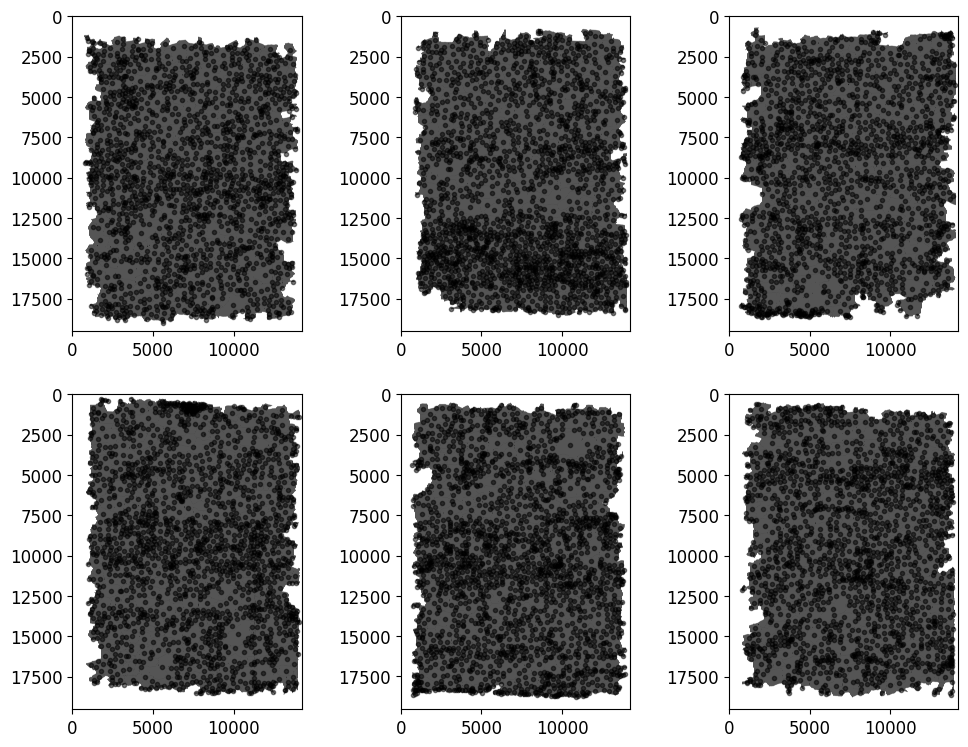

In [8]:
# PLot image with center of masses
keys_list = list(img_df.keys())
fig, ax = plt.subplots(2, 3,figsize=(12,9))
for i in range(2):    
    for j in range(3):
        key = keys_list[j+i*3]
        df1 = df["NEEM_LM3676"][df["NEEM_LM3676"].crop_img==j+i*3]
        df1 = df1[df1["area"] > 4000]
        ax[i,j].imshow(img_df[key],cmap="gray")
        ax[i,j].plot(df1["centroid_x"],df1["centroid_y"],".",color='black',alpha=0.5)
#fig.tight_layout()
fig.show()

### 3. Create DF with area and depth

In [8]:
# add depth to df
df_new = {}
depth_img_acc = 0
px_to_m = 1/200/1000
px_to_mm = 1/200
y_top_list = [-100,17000,33000,54157,71000,90000] # Matching peaks by eye
for bag in df.keys():
    df_new[bag] = pd.DataFrame(columns= ["area","centroid_x","centroid_y","crop_img","depth[m]"])
    bag_top = (int(bag[-4:])-1)*0.55
    for i in range(6):
        df1 = df[bag][df[bag].crop_img==i].copy()
        df1 = df1[df1["area"] > 4000] # Cut-off threshold
        #y_min = np.min(df1.centroid_y)
        #df1["depth[m]"] = bag_top + (gap/2 + gap * i + depth_img_acc + df1.centroid_y - y_min) * px_to_m
        y_top = y_top_list[i]
        df1["depth[m]"] = bag_top + (df1.centroid_y + y_top)*px_to_m
        df_new[bag] = pd.concat([df_new[bag],df1],ignore_index=True)
        #depth_img_acc = l_LASM_list_accumulated[i]
    df_new[bag] = df_new[bag].sort_values(by=["depth[m]"])
    df_new[bag] = df_new[bag].reset_index(drop=True)
df_new["NEEM_LM3676"].head()

,area,centroid_x,centroid_y,crop_img,depth[m]
0,60155,923,1352,0,2021.256260
1,12549,4073,1399,0,2021.256495
2,50908,3148,1432,0,2021.256660
3,13982,10799,1487,0,2021.256935
4,52095,11363,1497,0,2021.256985


In [9]:
# make 1mm resolution with 500px intervalls like with xLASM data
def sizes_depth(df,interval):
    """
    create dataset of grain sizes over depth for each bag
    ----------------------------------------------
    param: (dict) df: dictonary of dataframes with grain sizes
    param: (int) interval: interval in mm
    return: (dict) df_1mm: dictonary of dataframes with grain sizes over 1mm resolution
    """
    df_1mm = {}
    for bag in df.keys(): #loop over bags
        print(bag)
        df_1mm[bag] = pd.DataFrame(columns=["area","depth[m]","crop_img"])
        for i in range(6):
            df_crop = df[bag][df[bag].crop_img==i]
            depth_start = int(df_crop["depth[m]"].iloc[0]*1000)
            depth_end = int(df_crop["depth[m]"].iloc[-1]*1000)
            print(depth_end-depth_start)
            for ii in range(depth_end-depth_start)[5:-5]:
                depth = depth_start + ii + 0.5
                df_interval= df[bag][df[bag]["depth[m]"]>=(depth-interval)/1000]
                df_interval = df_interval[df_interval["depth[m]"]<(depth+interval)/1000]
                new_size = np.mean(df_interval.area)
                new_df = pd.DataFrame([[new_size,depth/1000,i]],columns=["area","depth[m]","crop_img"])
                df_1mm[bag] = pd.concat([df_1mm[bag],new_df],ignore_index=True)
    return df_1mm

In [10]:
interval_half = 5 #interval size: 1000 pixel = 5mm
df_1mm = sizes_depth(df_new,interval_half)
df_1mm["NEEM_LM3676"].head(5)

NEEM_LM3676
88
88
89
91
90
90


,area,depth[m],crop_img
0,126233.376471,2021.2615,0
1,129170.346591,2021.2625,0
2,131221.927083,2021.2635,0
3,126728.081218,2021.2645,0
4,125725.944724,2021.2655,0


### 4. Compare Binder and xLASM data 

In [11]:
# Load xLASM
resolution_mm = {"10": 10}
df_sizes = {}
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_sizes_depth/"

for key in resolution_mm.keys():
    print(key)
    path = file_path + "grain_data_interp_{}mm.csv".format(resolution_mm[key])
    df_sizes[key] = pd.read_csv(path)
df_sizes[list(df_sizes.keys())[0]].head()

10


,depth[m],equivalent_diameter[px],grain_size[px]
0,2002.5525,311.282395,2.572660e+06
1,2002.5535,306.918161,2.484274e+06
2,2002.5545,307.574230,2.486482e+06
3,2002.5555,315.558276,2.645217e+06
4,2002.5565,312.389430,2.606206e+06


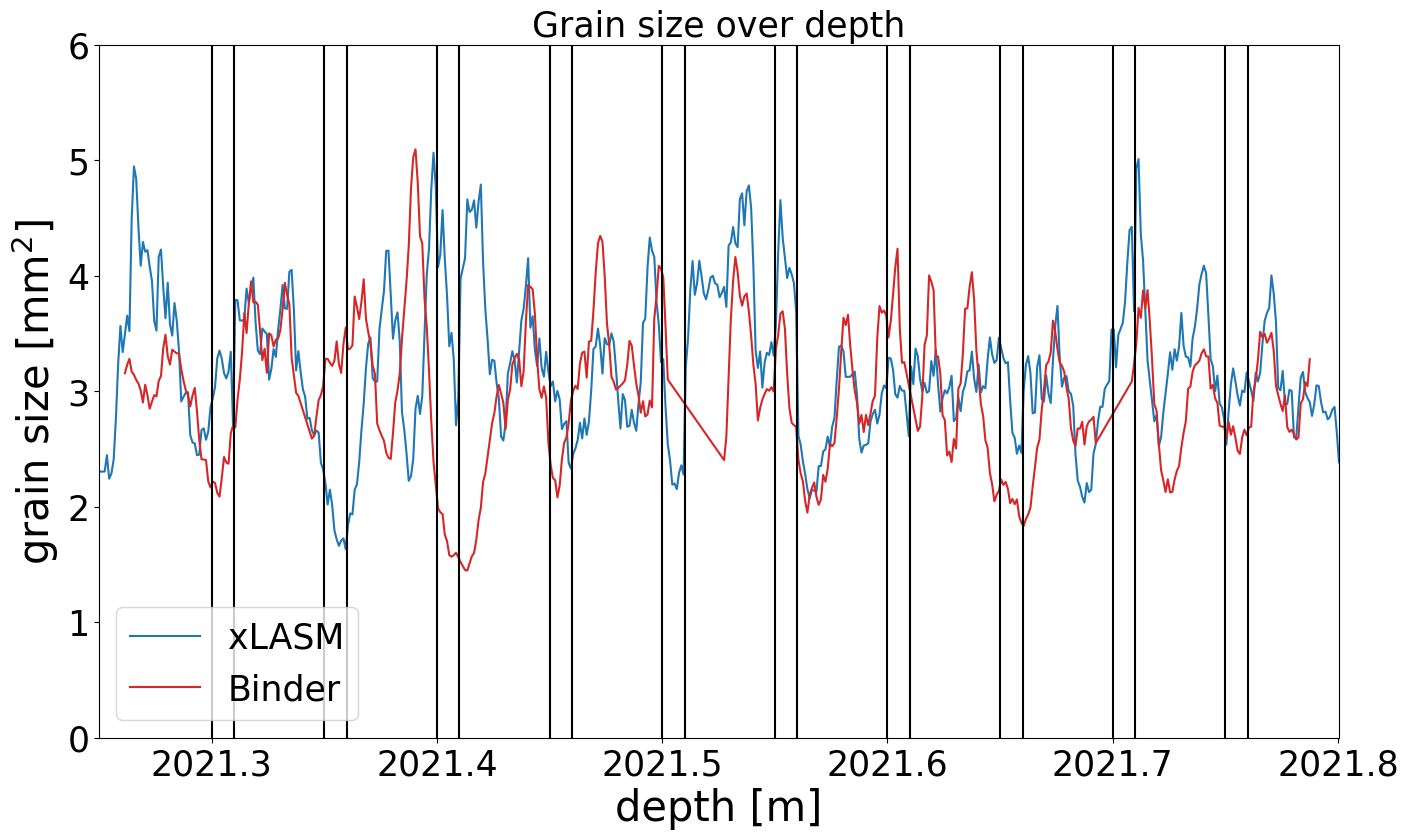

In [12]:
# PLot Binder and xLASM data with vertical lines to mark cropped xLASM images
fig, ax = plt.subplots(1, 1,figsize=(16,9))
line1, = ax.plot(df_sizes["10"]["depth[m]"],df_sizes["10"]["grain_size[px]"]/5**2*px_to_mm**2,color="tab:blue",ls="-") #Use 500px=2.5mm as xerr
line2, = ax.plot(df_1mm["NEEM_LM3676"]["depth[m]"],df_1mm["NEEM_LM3676"]["area"]*px_to_mm**2,color="tab:red",ls="-")
for i in range(1,11):
    ax.vlines(x=3675*0.55+0.05*i,ymin=0,ymax=6,color="black")
for i in range(0,10):
    ax.vlines(x=3675*0.55+0.06+0.05*i,ymin=0,ymax=6,color="black")
ax.ticklabel_format(useOffset=False)
ax.set(title="Grain size over depth",xlabel="depth [m]",ylabel="grain size [mm$^2$]",xlim=(3675*0.55,3675*0.55+l_xLASM/100),ylim=(0,6))
ax.legend([line1, line2], ["xLASM","Binder"])
#fig.tight_layout()
#fig.savefig("Plots/10_Binder_vs_xLASM.png",dpi=100)
fig.show()

mean of xLASM:  3.22 +  0.63
mean of LASM:  2.99 +  0.62


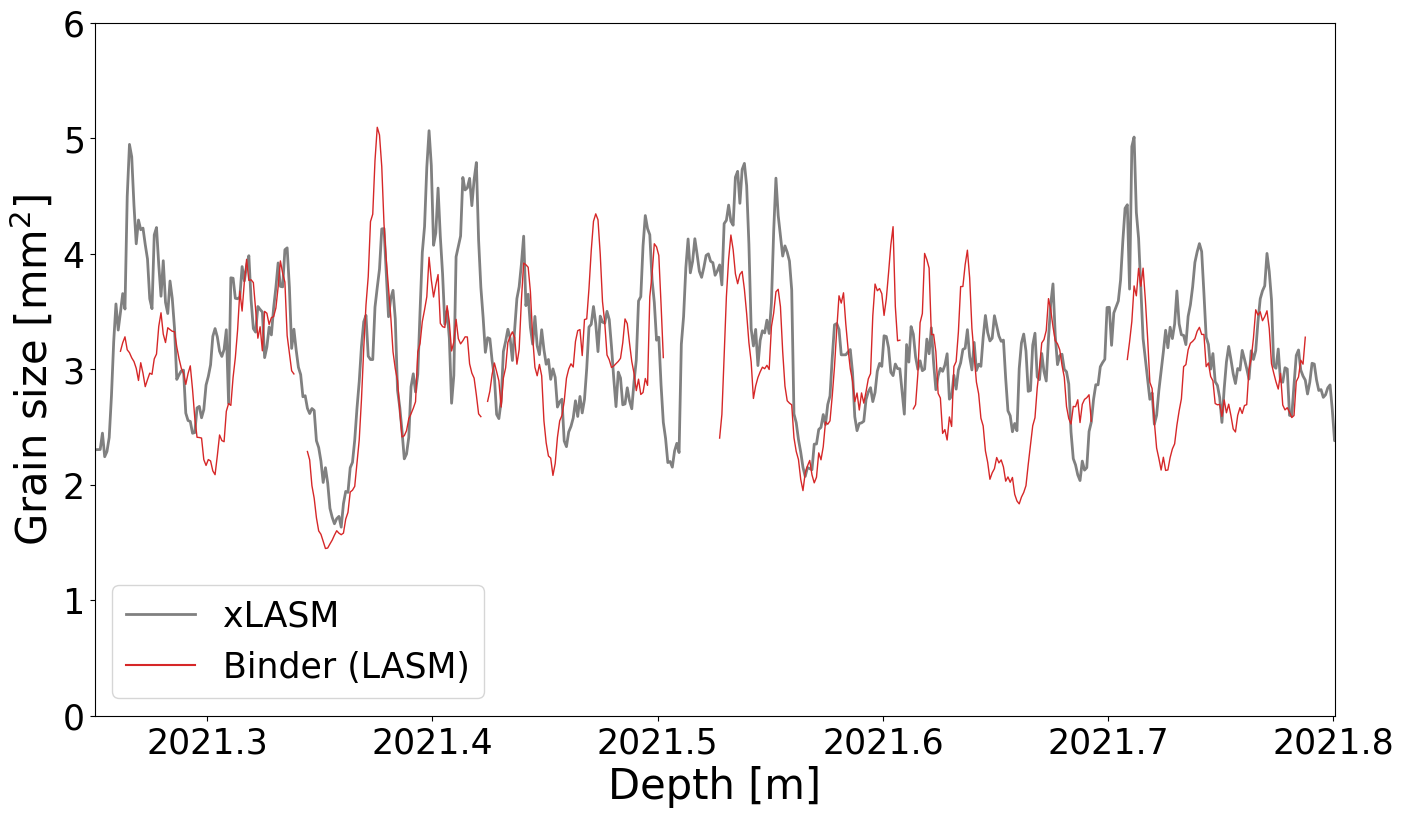

In [14]:
# PLot Binder and xLASM data
df_sizes_3676 = df_sizes["10"][df_sizes["10"]["depth[m]"]<3675*0.55+l_xLASM/100]
df_sizes_3676 = df_sizes_3676[df_sizes_3676["depth[m]"]>3675*0.55]

fig, ax = plt.subplots(1, 1,figsize=(16,9))
line1, = ax.plot(df_sizes["10"]["depth[m]"],df_sizes["10"]["grain_size[px]"]/5**2*px_to_mm**2,color="gray",ls="-",lw=2) #Use 500px=2.5mm as xerr
#line2, = ax.plot(df_1mm["NEEM_LM3676"]["depth[m]"],df_1mm["NEEM_LM3676"]["area"]*px_to_mm**2,color="black",ls="-")
for i in range(6):
    df3 = df_1mm["NEEM_LM3676"][df_1mm["NEEM_LM3676"]["crop_img"]==i].copy()
    if i==1: # Reverse second subsample for better match
        df3["depth[m]"] = df3["depth[m]"].values[::-1]
        df3 = df3.sort_values(by=["depth[m]"])
    ax.plot(df3[["depth[m]"]],df3["area"]*px_to_mm**2,ls="-",lw=1,color="tab:red")
ax.ticklabel_format(useOffset=False)
ax.set_xlabel(xlabel="Depth [m]")
ax.set_ylabel(ylabel="Grain size [mm$^2$]")
ax.set(xlim=(3675*0.55,3675*0.55+l_xLASM/100),ylim=(0,6))
ax.legend([line1, line2], ["xLASM","Binder (LASM)"])
#fig.tight_layout()
fig.savefig("Plots/10_Binder_vs_xLASM.png",dpi=100)
fig.show()
print("mean of xLASM: ",round(np.mean(df_sizes_3676["grain_size[px]"])/5**2*px_to_mm**2,2),"+ ", round(np.std(df_sizes_3676["grain_size[px]"])/5**2*px_to_mm**2,2))
print("mean of LASM: ",round(np.mean(df_1mm["NEEM_LM3676"]["area"])*px_to_mm**2,2),"+ ",round(np.std(df_1mm["NEEM_LM3676"]["area"])*px_to_mm**2,2))

### 5. Plot distributions

In [15]:
# Import raw xLASM grain data for bag 3676
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_properties/"
bag_list = ["nmx3676c_1","nmx3676c_2"]

def read_csv(path,bags):
    """
    read in csv files with grain size data and put it in dict of dataframes
    --------------------------------------
    param: (str) path: path of csv files
    param: (array) bags: list of bag name strings
    return: (dict) df: dictionary with containing DFs of data
    """
    df = {}
    for i in range(len(bags)):
        bag = str(bags[i])
        print(bag)
        if path != None:
            os.chdir(path + bag)    
        files = glob.glob("*.csv")
        print("# files:",len(files))
        files = Tcl().call('lsort', '-dict', files) #sort csv files after name
        df[bag] = pd.DataFrame()
        for i in range(len(files)):
            file = files[i]
            new_df = pd.read_csv(file)
            new_col = np.ones(new_df.shape[0])*i
            new_col = new_col.astype(int)
            new_df["crop_image"] = new_col
            df[bag] = pd.concat([df[bag],new_df],ignore_index=True)
    os.chdir("/home/jovyan/work/Master Thesis")
    return df

In [16]:
df_prop_xLASM = read_csv(file_path,bag_list)
print("Shape of dataframes: ",df_prop_xLASM["nmx3676c_1"].shape)
df_prop_xLASM["nmx3676c_1"].head()

nmx3676c_1
# files: 11
nmx3676c_2
# files: 11
Shape of dataframes:  (95489, 10)


,Unnamed: 0,area,equivalent_diameter,centroid_x,centroid_y,orientation,major_axis_length,minor_axis_length,perimeter,crop_image
0,1,250,3.568248,769.3,3.9,-62.012831,8.044211,2.022538,9.414214,0
1,2,25,1.128379,747.0,4.0,45.000016,0.000000,0.000000,0.000000,0
2,3,25,1.128379,773.0,4.0,45.000016,0.000000,0.000000,0.000000,0
3,4,100,2.256758,748.5,6.0,31.717486,3.236068,1.236068,4.414214,0
4,5,50,1.595769,744.0,6.5,0.000000,2.000000,0.000000,0.000000,0


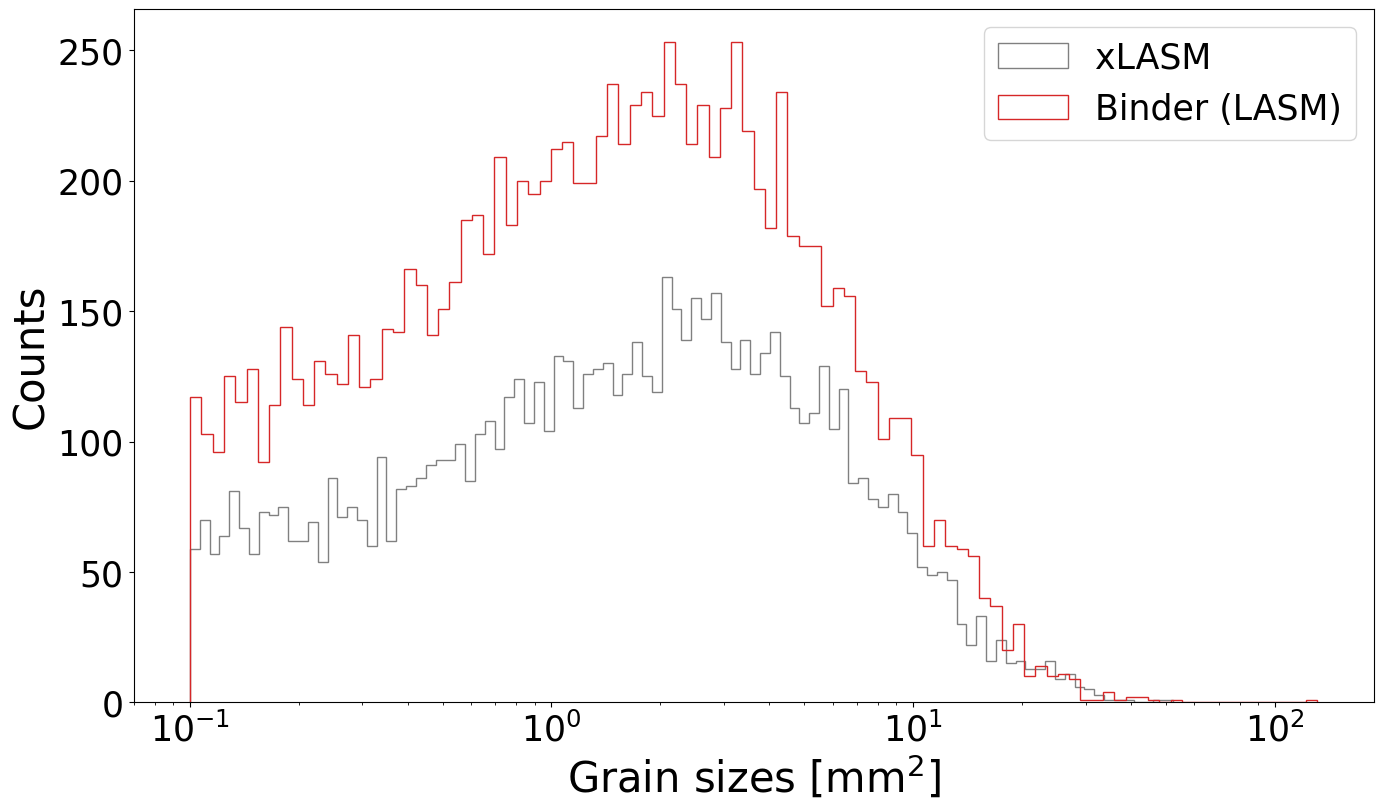

In [18]:
Nbins = 100
cut_off = 100000
xmin = cut_off/1e6
xmax = 20

sizes_mm = np.array([])
for bag in df_prop_xLASM.keys():
    df_prop_xLASM[bag] = df_prop_xLASM[bag][df_prop_xLASM[bag].area > cut_off]
    new_array = np.array(df_prop_xLASM[bag]["area"]/1000000)
    sizes_mm = np.concatenate((sizes_mm, new_array))


counts, bin_edges = np.histogram(sizes_mm, bins=Nbins)
logbins = np.logspace(np.log10(bin_edges[0]),np.log10(bin_edges[-1]),len(bin_edges))

counts1, bin_edges1 = np.histogram(df_new["NEEM_LM3676"]["area"]*px_to_mm**2,bins=Nbins)
logbins1 = np.logspace(np.log10(bin_edges1[0]),np.log10(bin_edges1[-1]),len(bin_edges1))


fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(sizes_mm, bins=logbins,label="xLASM",range=(xmin, xmax),histtype="step",color="gray",lw=1)
ax.hist(df_new["NEEM_LM3676"]["area"]*px_to_mm**2, bins=logbins1,range=(xmin, xmax),histtype="step",color="tab:red",label="Binder (LASM)")
ax.set_xlabel(xlabel='Grain sizes [mm$^2$]')
ax.set_ylabel(ylabel='Counts')
ax.ticklabel_format(axis="x",style="plain")
#ax.set(title="Grain size distribution")
ax.set_xscale('log')
ax.legend()
fig.savefig("Plots/10_grain_size_distribution.png",dpi=100);

### 6. Comparison to dust and Ca2+

In [19]:
# Load interpolated CFA data
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/CFA_interpolated/"

path = file_path + "CFA_interpolated.csv"
CFA_interp_slic = pd.read_csv(path)
CFA_interp_slic.head()

,Depth top (m),Cond (mikroS/cm),Na+ (ng/g),Ca++ (ng/g),Dust (#/mL) [SD>1.0],NH4+ (ng/g),NO3- (ng/g),H2O2 (ng/g),age (yr b2k)
0,2002.551,1.044638,35.386801,55.215085,12756.954682,1.126816,64.802555,NaN,71186.178182
1,2002.552,1.053359,34.908770,55.349388,12533.003895,1.146882,64.671126,NaN,71186.356364
2,2002.553,1.062309,34.420666,55.475033,12295.928952,1.166981,64.537724,NaN,71186.534545
3,2002.554,1.071514,33.925007,55.593180,12045.890426,1.187068,64.403140,NaN,71186.712727
4,2002.555,1.081003,33.424313,55.704991,11783.048888,1.207099,64.268160,NaN,71186.890909


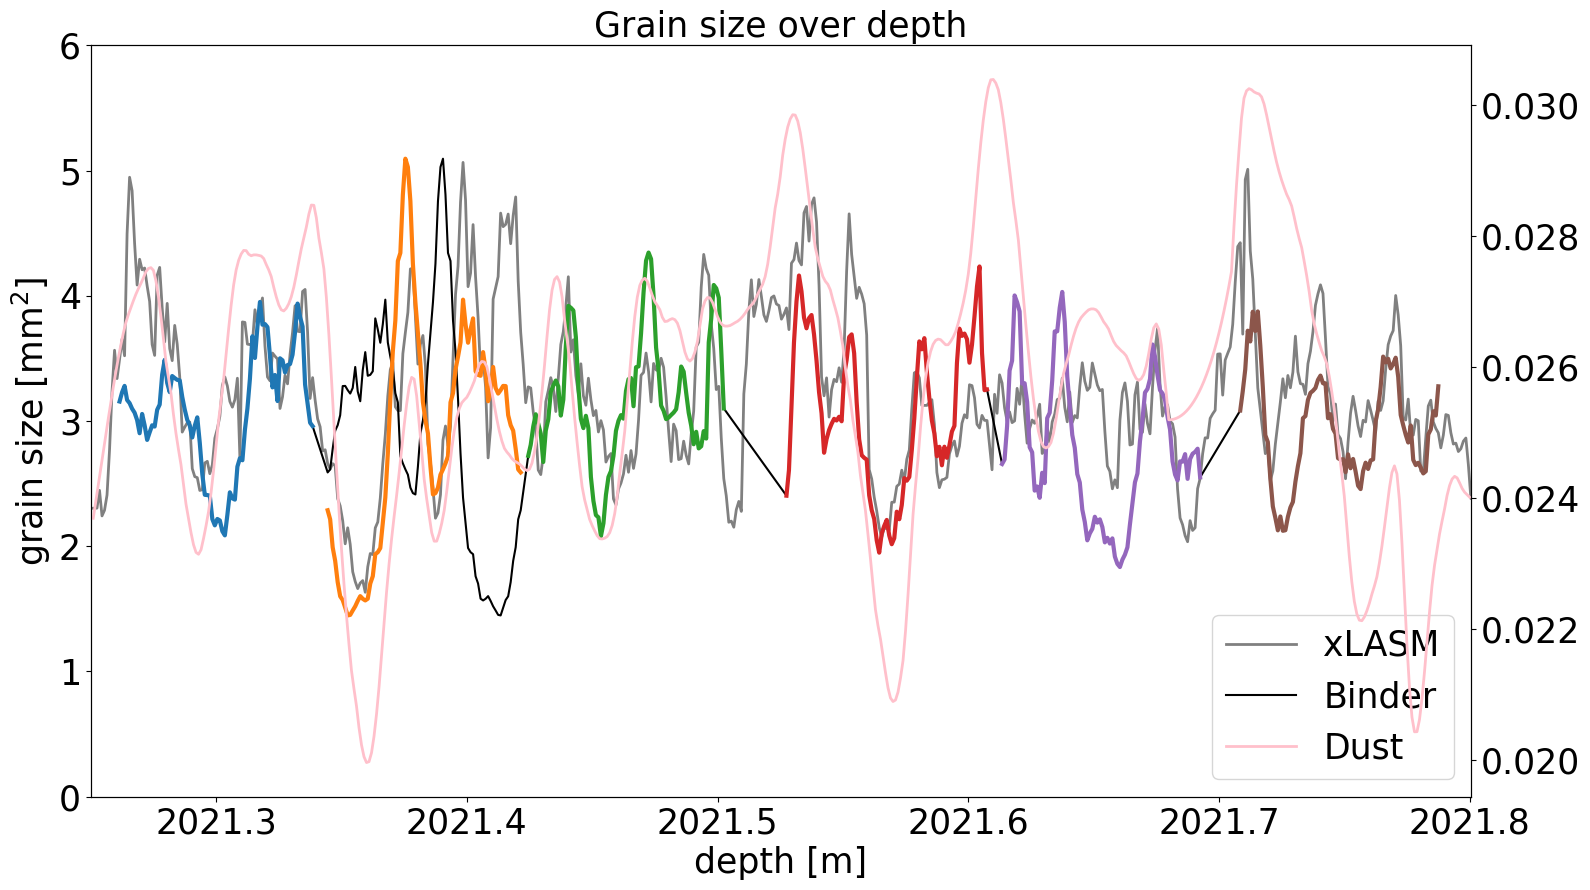

In [20]:
CFA_interp_3676 = CFA_interp_slic[CFA_interp_slic["Depth top (m)"]<(3676)*0.55]
CFA_interp_3676 = CFA_interp_3676[CFA_interp_3676["Depth top (m)"]>(3676-1)*0.55]

# PLot Binder and xLASM data
fig, ax = plt.subplots(1, 1,figsize=(16,9))
ax2 = ax.twinx()
#line3, = ax2.plot(CFA_interp_3676["Depth top (m)"], 1/CFA_interp_3676["Dust (#/mL) [SD>1.0]"], '-',color="pink",lw=2)
line3, = ax2.plot(CFA_interp_3676["Depth top (m)"], 1/CFA_interp_3676["Ca++ (ng/g)"], '-',color="pink",lw=2)
line1, = ax.plot(df_sizes["10"]["depth[m]"],df_sizes["10"]["grain_size[px]"]/5**2*px_to_mm**2,color="gray",ls="-",lw=2) #Use 500px=2.5mm as xerr
line2, = ax.plot(df_1mm["NEEM_LM3676"]["depth[m]"],df_1mm["NEEM_LM3676"]["area"]*px_to_mm**2,color="black",ls="-")
for i in range(6):
    df3 = df_1mm["NEEM_LM3676"][df_1mm["NEEM_LM3676"]["crop_img"]==i].copy()
    if i==1:
        df3["depth[m]"] = df3["depth[m]"].values[::-1]
        df3 = df3.sort_values(by=["depth[m]"])
    ax.plot(df3[["depth[m]"]],df3["area"]*px_to_mm**2,ls="-",lw=3)
ax.ticklabel_format(useOffset=False)
ax.set(title="Grain size over depth",xlabel="depth [m]",ylabel="grain size [mm$^2$]",xlim=(3675*0.55,3675*0.55+l_xLASM/100),ylim=(0,6))
ax.legend([line1, line2, line3], ["xLASM","Binder","Dust"])
fig.tight_layout()
#fig.savefig("Plots/10_Binder_vs_xLASM.png",dpi=100)
fig.show()



### 7. Compare to linescan gray values

In [21]:
# Load Linescan
path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/Linescan_gray_values_interpolated/gray_interpolated.csv"
df_gray = pd.read_csv(path)
df_gray.head()

,depth[m],gray_value,gray_value_err
0,2002.556,36.016062,16.138655
1,2002.557,32.573303,14.858734
2,2002.558,30.686754,14.663540
3,2002.559,28.235302,14.862442
4,2002.560,25.326288,13.658646


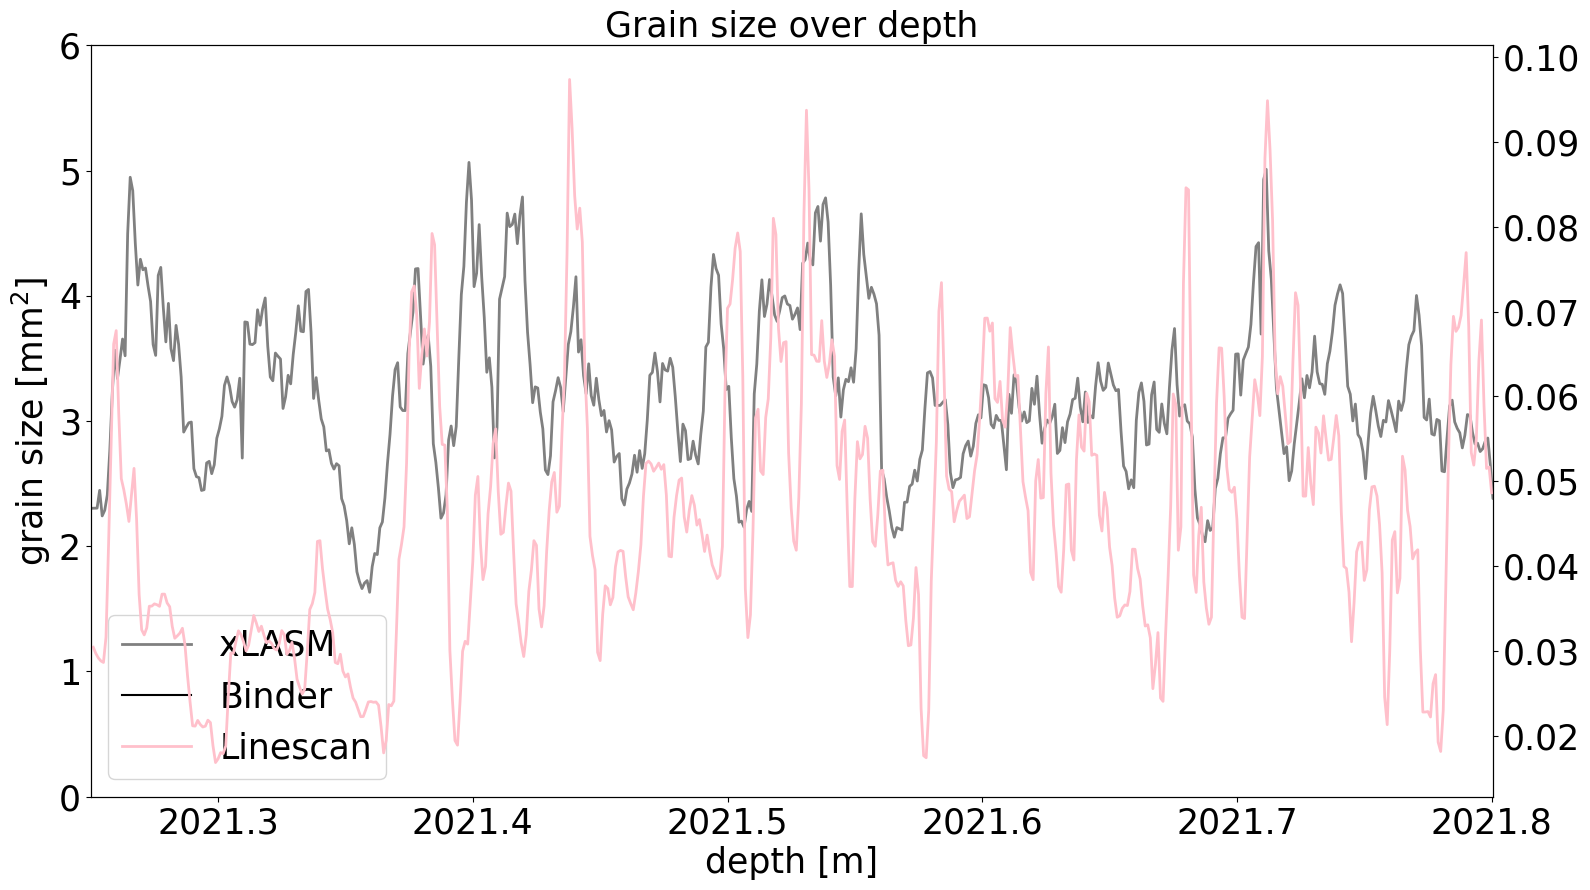

In [22]:
df_gray_slic = df_gray[df_gray["depth[m]"]<(3676)*0.55]
df_gray_slic = df_gray_slic[df_gray_slic["depth[m]"]>(3676-1)*0.55]

# PLot Binder and xLASM data
fig, ax = plt.subplots(1, 1,figsize=(16,9))
ax2 = ax.twinx()
line3, = ax2.plot(df_gray_slic["depth[m]"], 1/df_gray_slic["gray_value"], '-',color="pink",lw=2)
line1, = ax.plot(df_sizes["10"]["depth[m]"],df_sizes["10"]["grain_size[px]"]/5**2*px_to_mm**2,color="gray",ls="-",lw=2) #Use 500px=2.5mm as xerr
#line2, = ax.plot(df_1mm["NEEM_LM3676"]["depth[m]"],df_1mm["NEEM_LM3676"]["area"]*px_to_mm**2,color="black",ls="-")
#for i in range(6):
#    df3 = df_1mm["NEEM_LM3676"][df_1mm["NEEM_LM3676"]["crop_img"]==i]
#    ax.plot(df3[["depth[m]"]],df3["area"]*px_to_mm**2,ls="-",lw=3)
ax.ticklabel_format(useOffset=False)
ax.set(title="Grain size over depth",xlabel="depth [m]",ylabel="grain size [mm$^2$]",xlim=(3675*0.55,3675*0.55+l_xLASM/100),ylim=(0,6))
ax.legend([line1, line2, line3], ["xLASM","Binder","Linescan"])
fig.tight_layout()
#fig.savefig("Plots/10_Binder_vs_xLASM.png",dpi=100)
fig.show()



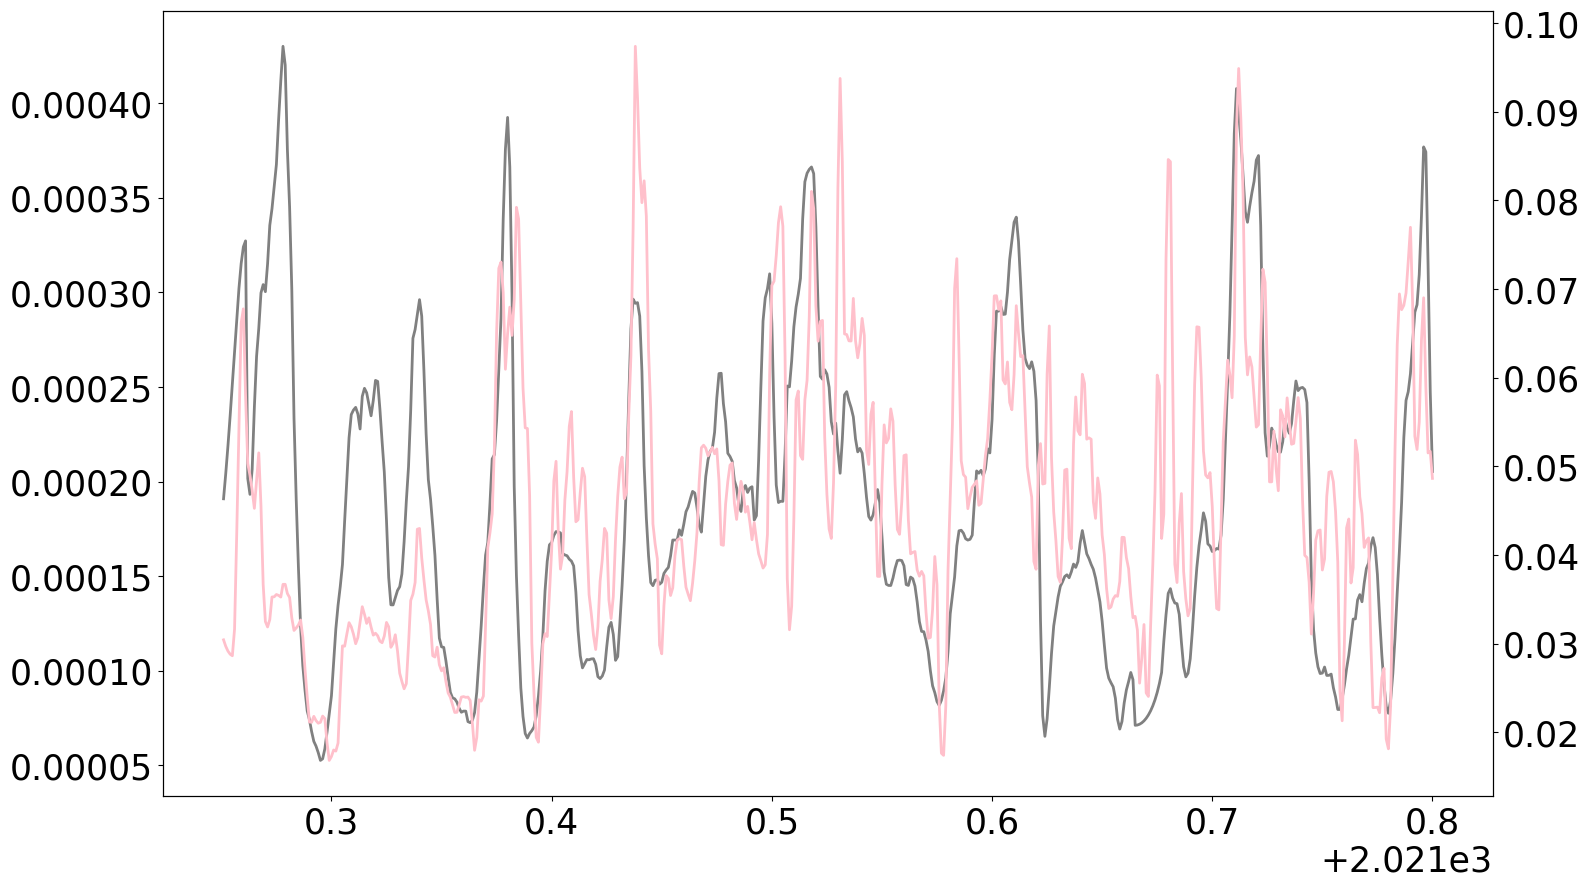

In [23]:
# Compare only dust and linescan gray for 3676
fig, ax = plt.subplots(1, 1,figsize=(16,9))
ax2 = ax.twinx()
line3, = ax2.plot(df_gray_slic["depth[m]"], 1/df_gray_slic["gray_value"], '-',color="pink",lw=2)
line2, = ax.plot(CFA_interp_3676["Depth top (m)"], 1/CFA_interp_3676["Dust (#/mL) [SD>1.0]"], '-',color="gray",lw=2)
fig.tight_layout()
#fig.savefig("Plots/10_Binder_vs_xLASM.png",dpi=100)
fig.show()

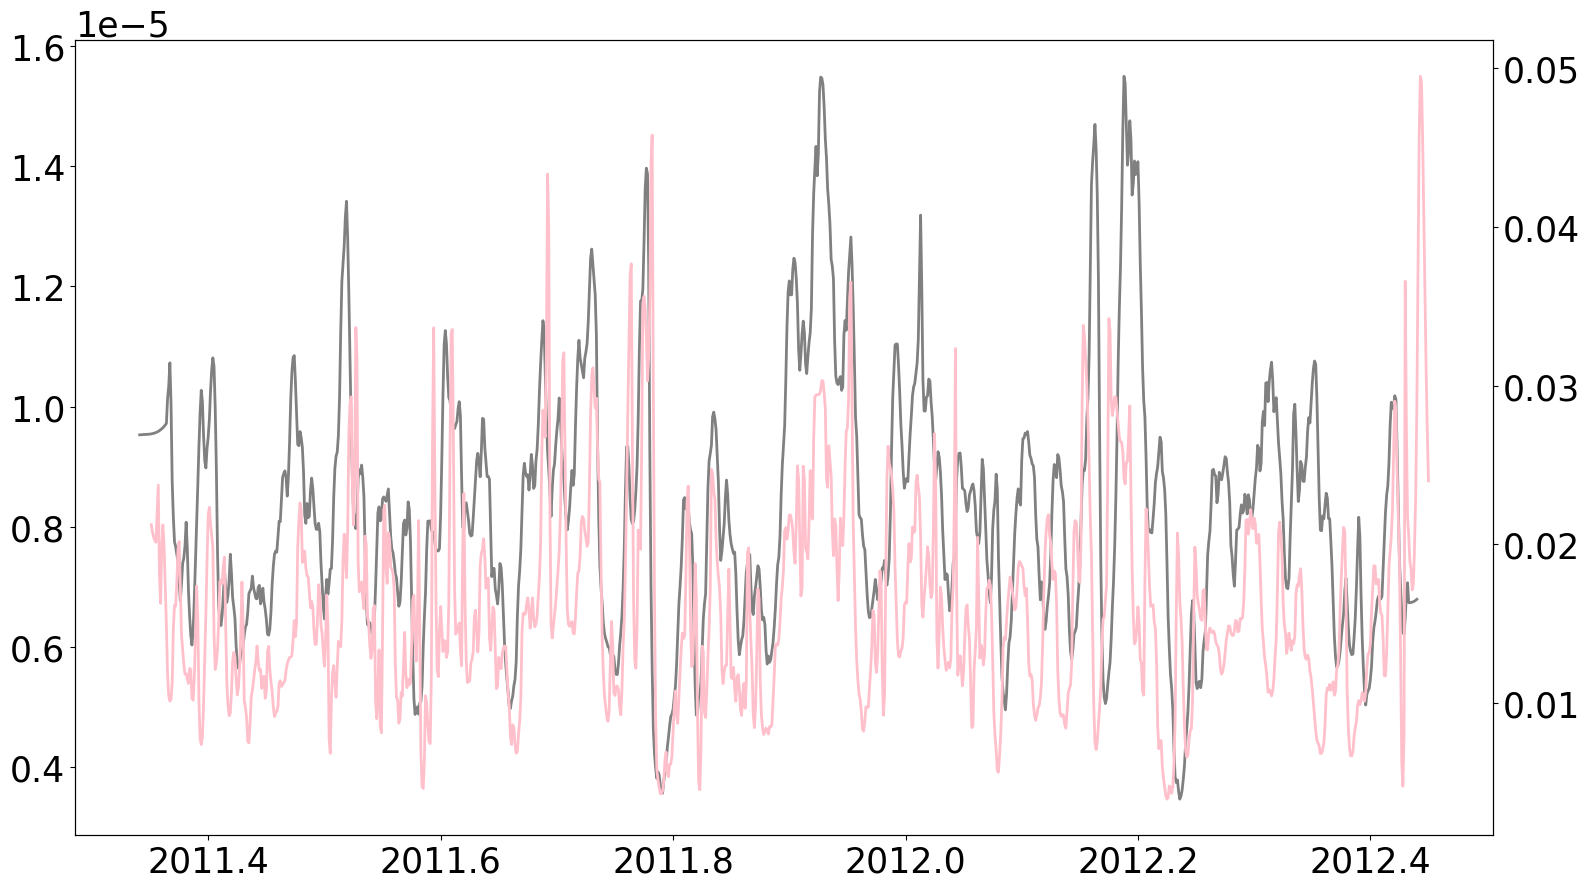

In [24]:
# Vergleich dust und linescan in stadial
df_gray_slic1 = df_gray[df_gray["depth[m]"]<(3659)*0.55]
df_gray_slic1 = df_gray_slic1[df_gray_slic1["depth[m]"]>(3658-1)*0.55]
CFA_interp_3659 = CFA_interp_slic[CFA_interp_slic["Depth top (m)"]<(3659)*0.55]
CFA_interp_3659 = CFA_interp_3659[CFA_interp_3659["Depth top (m)"]>(3658-1)*0.55]

fig, ax = plt.subplots(1, 1,figsize=(16,9))
ax2 = ax.twinx()
line3, = ax2.plot(df_gray_slic1["depth[m]"], 1/df_gray_slic1["gray_value"], '-',color="pink",lw=2)
line2, = ax.plot(CFA_interp_3659["Depth top (m)"]-0.01, 1/CFA_interp_3659["Dust (#/mL) [SD>1.0]"], '-',color="gray",lw=2)
fig.tight_layout()
#fig.savefig("Plots/10_Binder_vs_xLASM.png",dpi=100)
fig.show()

### 8. Plot everything: xLASM grain size, LASM, grain size, Linescan gray values, Dust and CA2+

In [25]:
# Resolution: 200px = 1cm
px_to_m = 5e-5
len_std = 0.55*2/px_to_m
NEEM_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/LineScan/NEEM/VisStrat/0_All_Bags_sorted/0_all/"
bag_numbers = np.arange(3642,3688,2)
step_size = 20 #1mm = 20px


gray_df = pd.DataFrame(columns=["depth[m]","gray_value","gray_value_err","bag"])
for bag in bag_numbers:
    print(bag)
    n = 20
    if bag<3656 or bag>3664:
        n = 11
    file_name = "{}_pass{}_1200.bmp".format(bag,n)
    img_path = join(NEEM_path,file_name)
    img = io.imread(img_path)
    img = img[280:-280,800:1500]
    img = np.flip(img.T,axis=1)
    len_img = np.shape(img)[1]
    delta_len = abs(int(len_img/step_size)*step_size-len_std) #length in m of cropped images
    depth_start = round((bag-1)*0.55+delta_len*px_to_m/2,4)
    for ii in range(int(len_img/step_size)):
        x_img = step_size*ii+step_size/2
        depth = round(depth_start+x_img*px_to_m,4)
        img1 = img[:,int(x_img-step_size/2):int(x_img+step_size/2)]
        #for i in np.argwhere(img1==255.): # if wanna take out 255 values
        #    img1[i[0],i[1]] = np.nan
        mean = np.nanmean(img1)
        std = np.nanstd(img1)
        new_df = pd.DataFrame([[depth,mean,std,bag]],columns=["depth[m]","gray_value","gray_value_err","bag"])
        gray_df = pd.concat([gray_df,new_df],ignore_index=True)
gray_df = gray_df.sort_values(by=["depth[m]"])

3642
3644
3646
3648
3650
3652
3654
3656
3658
3660
3662
3664
3666
3668
3670
3672
3674
3676
3678
3680
3682
3684
3686


In [26]:
# Load image of Linescan
bag = 3676
n = 20
if bag<3656 or bag>3664:
    n = 11
file_name = "{}_pass{}_1200.bmp".format(bag,n)
img_path = join(NEEM_path,file_name)
img = io.imread(img_path)
img = img[280:-280,800:1500]
img = np.flip(img.T,axis=1)
img.shape

(700, 21803)

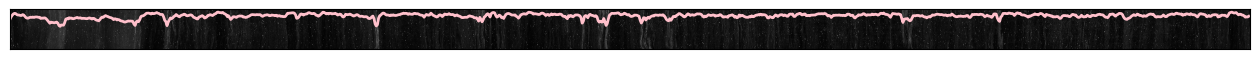

In [27]:
df_gray_slic1 = gray_df[gray_df["depth[m]"]<(3677)*0.55]
df_gray_slic1 = df_gray_slic1[df_gray_slic1["depth[m]"]>(3676-1)*0.55]

fig, ax = plt.subplots(1, 1,figsize=(16,9))
#line3, = ax.plot((df_gray_slic1["depth[m]"]-df_gray_slic1["depth[m]"].iloc[0])/px_to_m, 10000/df_gray_slic1["gray_value"], '-',color="pink",lw=2)
line3, = ax.plot((df_gray_slic1["depth[m]"]-df_gray_slic1["depth[m]"].iloc[0])/px_to_m, df_gray_slic1["gray_value"]*5, '-',color="pink",lw=2)
ax.imshow(img, cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
fig.show()

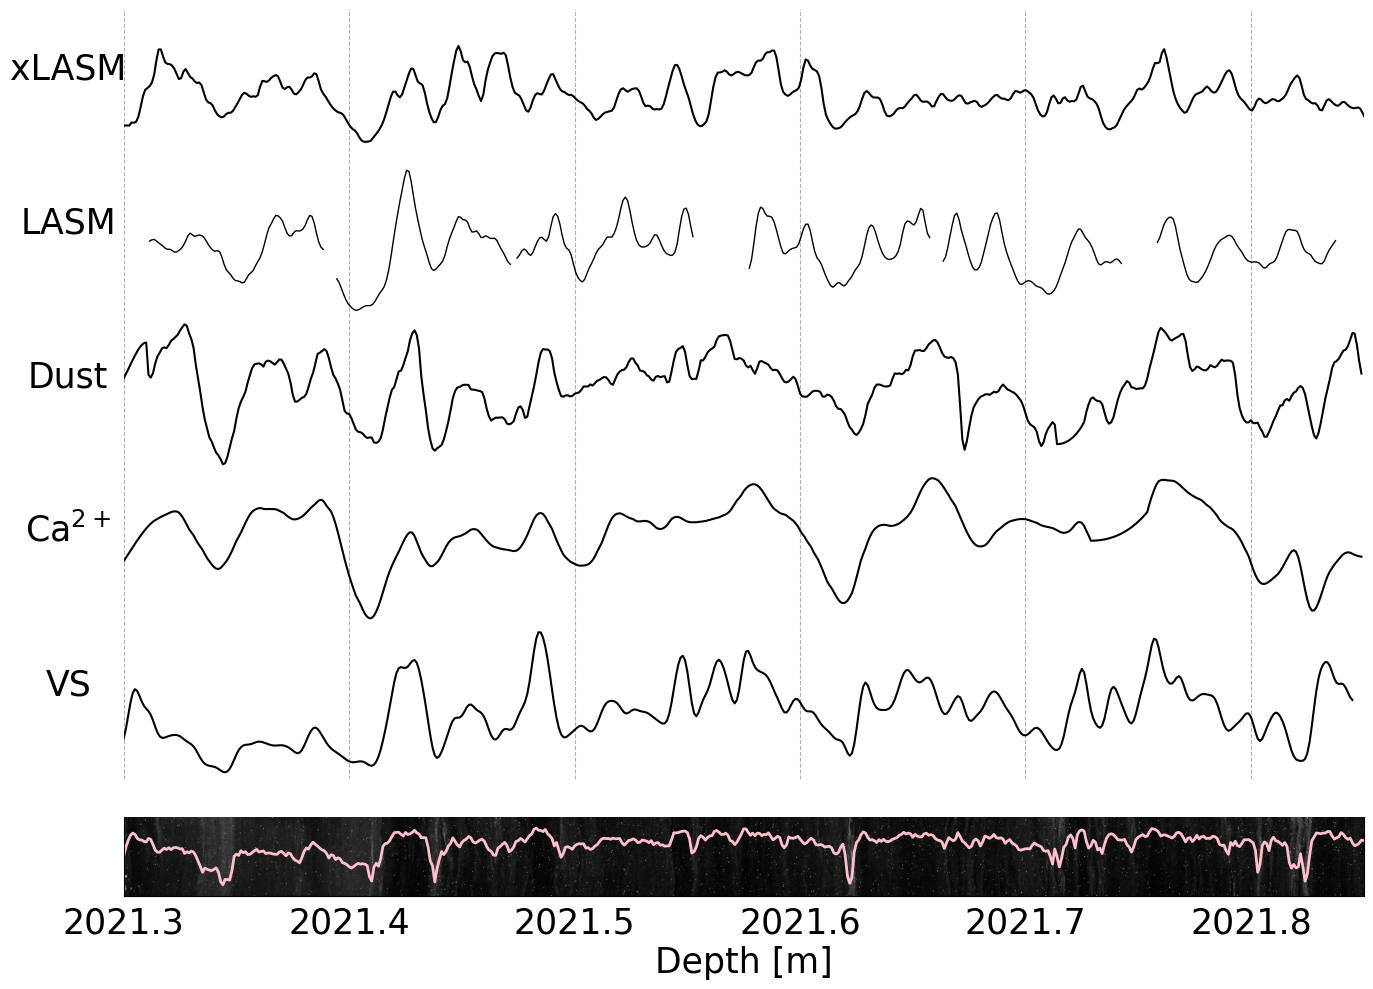

In [31]:
fig, ax = plt.subplots(6,1,figsize=(16, 12),sharex=True)

# Plot data
ax[0].plot((df_sizes["10"]["depth[m]"]-(3676-1)*0.55)/px_to_m,gaussian_filter1d(df_sizes["10"]["grain_size[px]"]/5**2*px_to_mm**2,1),'-',color="black",label="Grain size",alpha=1)
for i in range(6):
    df3 = df_1mm["NEEM_LM3676"][df_1mm["NEEM_LM3676"]["crop_img"]==i].copy()
    if i==1: # Reverse second subsample for better match
        df3["depth[m]"] = df3["depth[m]"].values[::-1]
        df3 = df3.sort_values(by=["depth[m]"])
    ax[1].plot((df3[["depth[m]"]]-(3676-1)*0.55)/px_to_m,gaussian_filter1d(df3["area"]*px_to_mm**2,1),ls="-",lw=1,color="black")
ax[2].semilogy((CFA_interp_3676["Depth top (m)"]-CFA_interp_3676["Depth top (m)"].iloc[0])/px_to_m, 1/CFA_interp_3676["Dust (#/mL) [SD>1.0]"]/1000, '-',color="black",label="Dust",alpha=1)
ax[3].semilogy((CFA_interp_3676["Depth top (m)"]-CFA_interp_3676["Depth top (m)"].iloc[0])/px_to_m, 1/CFA_interp_3676["Ca++ (ng/g)"], '-',color="black",label="Ca++",alpha=1)
ax[4].plot((df_gray_slic["depth[m]"]-df_gray_slic["depth[m]"].iloc[0])/px_to_m-80, gaussian_filter1d(1/df_gray_slic["gray_value"],2),'-',color="black",label="linescan gray",alpha=1)
ax[5].plot((df_gray_slic1["depth[m]"]-df_gray_slic1["depth[m]"].iloc[0])/px_to_m, df_gray_slic1["gray_value"]*10, '-',color="pink",lw=2)
ax[5].imshow(img, cmap="gray")


# Set axis labels
#ax[-1].set_xlabel('Depth top [m]')
ax[0].set_ylabel('xLASM',rotation=0,labelpad=40,fontsize=25)
ax[1].set_ylabel('LASM',rotation=0,labelpad=40,fontsize=25)
ax[2].set_ylabel('Dust',rotation=0,labelpad=40,fontsize=25)
ax[3].set_ylabel(r'Ca$^{2+}$',rotation=0,labelpad=40,fontsize=25)
ax[4].set_ylabel('VS',rotation=0,labelpad=40,fontsize=25)
ax[5].set_xlabel("Depth [m]",fontsize=25)

# Remove top and bottom spines from the axes
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[4].spines['top'].set_visible(False)
ax[5].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[3].spines['left'].set_visible(False)
ax[4].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[4].spines['bottom'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)


# Ticks and Labels on right side and remove x ticks
#ax[1].yaxis.tick_right()
#ax[3].yaxis.tick_right()
#ax[5].yaxis.tick_right()
ax[0].tick_params("x",bottom=False)
ax[0].tick_params("y",bottom=False)
ax[1].tick_params("x",bottom=False)
ax[2].tick_params("x",bottom=False)
ax[3].tick_params("x",bottom=False)
ax[4].tick_params("x",bottom=False)
ax[5].tick_params("x",bottom=False)

# axis limits
ax[0].set_xlim(xmin=0,xmax=0.55/px_to_m)
ax[0].set_ylim(ymin=1,ymax=6)
ax[0].set_yticks([], [])
ax[1].set_yticks([], [])
ax[2].set_yticks([], [])
ax[3].set_yticks([], [])
ax[4].set_yticks([], [])
ax[5].set_yticks([], [])
ax[5].ticklabel_format(axis="x",useOffset=False)
ax[5].set_xticks([0,0.1/px_to_m,0.2/px_to_m,0.3/px_to_m,0.4/px_to_m,0.5/px_to_m])
ax[5].set_xticklabels([round(3675*0.55,1),round(3675*0.55+0.1,1),round(3675*0.55+0.2,1),round(3675*0.55+0.3,1),round(3675*0.55+0.4,1),round(3675*0.55+0.5,1)])
ax[2].minorticks_off()
ax[3].minorticks_off()

# add grid
ax[0].grid(which='major', axis='x', linestyle='--')
ax[1].grid(which='major', axis='x', linestyle='--')
ax[2].grid(which='major', axis='x', linestyle='--')
ax[3].grid(which='major', axis='x', linestyle='--')
ax[4].grid(which='major', axis='x', linestyle='--')

#ax[0].ticklabel_format(axis="y",style="sci",scilimits=(0,0))
fig.subplots_adjust(hspace=0)
fig.savefig("Plots/10_CFA_vs_Linescan_vs_xLASM.png",dpi=100)
fig.show()